In [690]:
%reload_kedro

2020-06-06 20:34:57,586 - root - INFO - ** Kedro project Immunization Drop-outs
2020-06-06 20:34:57,587 - root - INFO - Defined global variable `context` and `catalog`


## Patients

Data Dictionary: patients_db.csv
* pat_id: The unique ID of the child.
* dob: The date of birth of the child.
* gender: The gender of the child.
* fac_id: The unique ID of the health facility the child received the vaccination.
* lat: The latitude of the facility.
* long: The longitude of the facility.
* district: The geographical district that the facility is located in.

In [691]:
dfp = catalog.load("patients")
dfp.head()

2020-06-06 20:34:57,593 - kedro.io.data_catalog - INFO - Loading data from `patients` (CSVDataSet)...


,Unnamed: 0,pat_id,fac_id,dob,gender,long,lat,region,district
0,0,1,51.0,2019-01-22,f,NaN,NaN,Ghanzi,Ghanzi
1,1,2,89.0,2019-11-12,f,24.877556,-18.370709,Chobe,Chobe
2,2,3,161.0,2019-11-03,m,25.249672,-20.490189,Central,Tutume
3,3,4,168.0,2019-04-17,f,25.579269,-21.412151,Central,Lethlakane
4,4,5,183.0,2018-12-08,m,28.487746,-22.571451,Central,Tuli


In [692]:
def remove_unnamed_column(df):
    """
    Remove columns leftover by df to csv conversion.
    """
    return df.drop('Unnamed: 0', 1)

In [693]:
dfp = remove_unnamed_column(dfp)
dfp.shape

(50000, 8)

Check if we have duplicate records.

In [694]:
len(dfp.pat_id.unique()) == dfp.shape[0]

True

Check for NaNs.

In [695]:
dfp.isnull().values.any()

True

In [696]:
dfp.isnull().sum().sum()

11846

In [697]:
dfp['dob'].isnull().sum()

0

In [698]:
dfp['gender'].isnull().sum()

1002

I will exclude records without gender from the dataset as I will be using it as a predictor.

In [699]:
dfp['fac_id'].isnull().sum()

2504

Facility ID column has a lot of nulls. Lets see if we can fill the missing information using other records.

How many facilities we have in the database?

In [700]:
len(dfp['fac_id'].unique())

346

In [701]:
len(dfp['region'].unique())

16

In [702]:
# list of facilities
fac_list = dfp['fac_id'].unique()
# region list
region_list = dfp['region'].unique()

In [703]:
dffac = dfp.drop(['pat_id', 'dob', 'gender'], 1)
# dftemp = dftemp[dftemp.region == region_list[0]]
dffac.head()

,fac_id,long,lat,region,district
0,51.0,NaN,NaN,Ghanzi,Ghanzi
1,89.0,24.877556,-18.370709,Chobe,Chobe
2,161.0,25.249672,-20.490189,Central,Tutume
3,168.0,25.579269,-21.412151,Central,Lethlakane
4,183.0,28.487746,-22.571451,Central,Tuli


In [704]:
dffac.shape

(50000, 5)

In [705]:
# sort fac_id - ascending order
dffac.sort_values(by=['fac_id'], inplace=True)
dffac.head()

,fac_id,long,lat,region,district
36903,1.0,NaN,NaN,North-West,Ngamiland East
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
15376,1.0,23.375396,-20.057104,North-West,Ngamiland East
16009,1.0,23.375396,-20.057104,North-West,Ngamiland East
14136,1.0,23.375396,-20.057104,North-West,Ngamiland East


In [706]:
# drop columns with Nan
dffac = dffac.dropna()

In [707]:
dffac.shape

(43621, 5)

In [708]:
dffac.head()

,fac_id,long,lat,region,district
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
15376,1.0,23.375396,-20.057104,North-West,Ngamiland East
16009,1.0,23.375396,-20.057104,North-West,Ngamiland East
14136,1.0,23.375396,-20.057104,North-West,Ngamiland East
8363,1.0,23.375396,-20.057104,North-West,Ngamiland East


In [709]:
# dropping ALL duplicte values 
dffac.drop_duplicates(subset ="fac_id", 
                       keep = 'first', 
                       inplace = True) 
dffac.head()

,fac_id,long,lat,region,district
37931,1.0,23.375396,-20.057104,North-West,Ngamiland East
21602,2.0,23.410550,-21.465240,Ghanzi,Ghanzi
45608,3.0,23.214604,-21.792671,Ghanzi,Ghanzi
12983,4.0,23.688444,-21.332783,Ghanzi,Ghanzi
21287,5.0,21.817487,-21.634937,Ghanzi,Ghanzi


In [710]:
dffac['fac_id'].isnull().sum()

0

In [711]:
len(dfp['fac_id'].unique()) == dffac['fac_id'].shape[0]

False

In [712]:
dffac['fac_id'].shape[0]

334

Still it looks like we lost 12 facilities out of 336 in the process. I will ignore this for now. If I had more time I would investigate further and look at a map to get district and region. Remove offending facilities at a later stage...

No more NaNs for `fac-id`. We can use this new dataframe to fill missing information so we don't loose records for our prediction.

In [713]:
def create_facility_df(df):
    """
    remove patient info 
    sort fac_id in ascending order 
    drop columns with Nan (assumption: there is at least one fac_id
    row with the whole information)
    dropping ALL duplicte values but the first
    reset index
    sanity check: fac_id != NaN
    """
    df = df.drop(['pat_id', 'dob', 'gender'], 1)
    df.sort_values(by=['fac_id'], inplace=True)
    df = df.dropna()
    df.drop_duplicates(subset ="fac_id", 
                       keep = 'first', 
                       inplace = True)
    df = df.reset_index(drop=True)
    assert df.fac_id.isnull().sum() == 0
    return df

In [714]:
dffac = create_facility_df(dfp)
dffac.head()

,fac_id,long,lat,region,district
0,1.0,23.375396,-20.057104,North-West,Ngamiland East
1,2.0,23.410550,-21.465240,Ghanzi,Ghanzi
2,3.0,23.214604,-21.792671,Ghanzi,Ghanzi
3,4.0,23.688444,-21.332783,Ghanzi,Ghanzi
4,5.0,21.817487,-21.634937,Ghanzi,Ghanzi


In [715]:
dffac.isnull().sum().sum()

0

In [716]:
len(dffac['long'].unique()) == dffac['fac_id'].shape[0]

True

In [717]:
len(dffac['lat'].unique()) == dffac['fac_id'].shape[0]

True

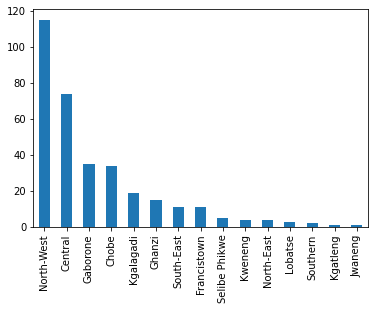

In [718]:
dffac['region'].value_counts().plot(kind='bar')

Lets go back to our patients now. I will first remove records with NaN gender.

In [719]:
def drop_null_gender(df):
    """
    Drop all records without gender field and reset index.
    """
    df.dropna(subset=['gender'], inplace=True)
    df = df.reset_index(drop=True)
    return df

In [720]:
dfp = drop_null_gender(dfp)
dfp.shape[0]

48998

In [721]:
dfp.isnull().sum().sum()

10586

In [722]:
dfp['fac_id'].isnull().sum()

2438

Now we will find indexes of those row and match them with our fac_id dataframe.

In [723]:
import pandas as pd
import numpy as np

In [724]:
index = dfp['fac_id'].index[dfp['fac_id'].apply(np.isnan)]
len(index)

2438

Since lat and long all unique for all facilities we can use one to match out fac_id.

In [725]:
def fill_missing_facid(df0, df1):
    """
    Since lat and long all unique for all facilities we 
    can use one to match out fac_id. Find index of NaN fac_id and 
    search facility ID dataframe for match on longitude.
    If there is no long, as we will assume no geo location
    was captured, remove records.
    df0: patient dataframe
    df1: facilities dataframe
    """
    ind = df0['fac_id'].index[df0['fac_id'].apply(np.isnan)]
    empty_idx = []
    for i in ind:
        long0 = df0.loc[i].long
        try:
            facid = df1[df1['long'] == long0]['fac_id'].values[0]
            df0.loc[i, 'fac_id'] = facid
        except IndexError:
            empty_idx.append(i)
    if empty_idx:
        df0 = df0.drop(df0.index[empty_idx])
        df0 = df0.reset_index(drop=True)
    return df0

In [726]:
dfp = fill_missing_facid(dfp, dffac)
dfp['fac_id'].isnull().sum() == 0

True

In [727]:
dfp.shape[0]

48801

In [728]:
dfp.isnull().sum().sum()

7740

Now we can remove offending facilities from earlier.

In [729]:
def remove_facilities(df0, df1):
    """
    Remove facilities from patient dataframe that are not present in 
    facilities dataframe
    df0: patient dataframe
    df1: facilities dataframe
    """
    bad_facid = list(set(list(df0['fac_id'].unique())) - set(list(df1['fac_id'])))
    idx = [df0[df0['fac_id'] == i].index.tolist() for i in bad_facid]
    bad_idx = [item for sublist in idx for item in sublist]
    
    df0.drop(df0.index[bad_idx], inplace=True)
    df0 = df0.reset_index(drop=True)
    return df0

In [730]:
dfp = remove_facilities(dfp, dffac)
dfp.shape[0]

47282

In [731]:
dfp.isnull().sum().sum()

4538

Still NaNs... Now we can use facility ID to fill missing data!

In [732]:
def fill_missing_values(df0, df1):
    """
    Find index of NaN values. For each index read fac_id. 
    Using that fac_id read long, lat, region and district 
    from facilities dataframe and write them to patient dataframe.
    df0: patient dataframe
    df1: facilities dataframe
    """
    ind = df0[df0.isnull().any(axis=1)].index
    for i in ind:
        facid = df0.loc[i].fac_id
        df0.loc[i, 'long'] = df1[df1.fac_id == facid].long.values[0]
        df0.loc[i, 'lat']  = df1[df1.fac_id == facid].lat.values[0]
        df0.loc[i, 'region']  = df1[df1.fac_id == facid].region.values[0]
        df0.loc[i, 'district'] = df1[df1.fac_id == facid].district.values[0]
    return df0

In [733]:
dfp = fill_missing_values(dfp, dffac)
dfp.isnull().sum().sum() == 0

True

In [734]:
50000 - dfp.shape[0]

2718

I removed about 5% of the data. This number could be improved with further investigation into geo location of the facilities.

Now wrap it all in one function to create `preprocessed_patients` dataset.

In [735]:
def preprocess_patients(df0, df1):
    """
    Bring all functions to create pre-processed df
    """
    df = remove_unnamed_column(df0)
    df = drop_null_gender(df)
    df = fill_missing_facid(df, df1)
    df = remove_facilities(df, df1)
    df = fill_missing_values(df, df1)
    return df

In [736]:
dfp = catalog.load("patients")
dfp = preprocess_patients(dfp, dffac)

2020-06-06 20:35:15,006 - kedro.io.data_catalog - INFO - Loading data from `patients` (CSVDataSet)...


## Immunization

In [739]:
dfi = catalog.load("immunization")
dfi.head()

2020-06-07 10:17:27,437 - kedro.io.data_catalog - INFO - Loading data from `immunization` (CSVDataSet)...


,Unnamed: 0,pat_id,vaccine,im_date,successful,reason_unsuccesful
0,0,1,OPV,2019-01-31,True,NaN
1,1,2,OPV,2019-11-12,True,NaN
2,2,3,OPV,2019-11-03,True,NaN
3,3,4,OPV,2019-06-01,True,NaN
4,4,5,OPV,2018-12-24,True,NaN


In [740]:
dfi = remove_unnamed_column(dfi)
dfi.shape

(276764, 5)